<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Loading-in-data" data-toc-modified-id="Loading-in-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading in data</a></span><ul class="toc-item"><li><span><a href="#pre-processing" data-toc-modified-id="pre-processing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>pre-processing</a></span></li><li><span><a href="#Spline-residual-fitting" data-toc-modified-id="Spline-residual-fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Spline residual fitting</a></span><ul class="toc-item"><li><span><a href="#qnorm-residuals" data-toc-modified-id="qnorm-residuals-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>qnorm residuals</a></span></li></ul></li></ul></li></ul></div>

In [ ]:
Read counts are converted to log2 RPM. Pseudocount of 1 is added to prevent taking log(0)

Gene-targeting guides are then z-normalized by the control sgRNA distribution. 

Guide fold changes were calculated as residuals fit to a natural cubic spline with 4 degrees of freedom For the genome973 scale screens, fold changes from all four pools were quantile normalized with gene-wise mean
974 imputation before downstream analyses.

# Imports

In [2]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.rc('pdf',fonttype=42)
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression
from patsy import cr

from scipy.stats import norm
from scipy.stats import gaussian_kde
from statsmodels.stats.multitest import multipletests

from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap

from scipy.stats import zscore, spearmanr, pearsonr

from tqdm import tqdm

In [3]:
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
def density_scatter(x ,y, ax=None, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )


    return ax

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Loading in data

In [6]:
# load data
counts_f = '../data/Renca_GWS_counts.txt'
design_f = '../data/Renca_replicate_map.txt'
ctrl_sg_f = '../data/control_guide_IDs.txt'
ctrl_gene_f = '../data/control_guide_genes.txt'
chip_f = '../data/chip/uniq_ID_chip.txt'

counts = pd.read_table(counts_f, index_col=0)
design = pd.read_table(design_f, index_col=0)
ctrl_sg = pd.read_table(ctrl_sg_f, header=None, squeeze=True)
chip = pd.read_table(chip_f, index_col=0)

In [7]:
counts
#guide X replicate counts matrix

,Renca_Input,Renca_Output,Renca_NSG_1,Renca_NSG_2,Renca_NSG_3,Renca_NSG_4,Renca_NSG_5,Renca_NSG_6,Renca_NSG_7,Renca_NSG_8,...,Renca_IO_1,Renca_IO_2,Renca_IO_3,Renca_IO_4,Renca_IO_5,Renca_IO_6,Renca_IO_7,Renca_IO_8,Renca_IO_9,Renca_IO_10
ID,,,,,,,,,,,,,,,,,,,,,
s_0,503,427,1006,755,414,423,372,247,272,775,...,450,122,57,432,807,270,21.0,454,28,NaN
s_1,423,663,1268,379,508,269,483,375,218,572,...,1206,308,132,279,392,560,37.0,126,20,NaN
s_2,923,1182,1208,782,550,1257,979,430,650,983,...,1612,977,1096,888,1676,297,309.0,1476,33,NaN
s_3,767,703,1661,1070,161,631,848,422,377,490,...,693,188,508,1372,2089,818,160.0,338,13,NaN
s_4,564,286,800,316,50,374,498,272,269,556,...,183,204,280,1750,556,63,11.0,579,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_82628,1219,1744,1264,200,307,681,677,640,599,534,...,726,683,329,97,206,405,508.0,347,645,176.0
s_82629,1738,1776,1288,834,938,559,858,606,1150,831,...,1243,452,599,85,605,627,290.0,1697,144,447.0
s_82630,2691,1949,1690,800,1509,1014,1285,1008,1178,994,...,1311,374,532,498,842,339,2094.0,350,747,516.0


In [8]:
design
#defines comparisons used for calculating normalized fold change (Sample vs Control)

,cell_line,condition,Sample,Control
Replicate Header,,,,
Renca_Input,Renca,Input,Renca_Input,NaN
Renca_Output,Renca,Output,Renca_Output,Renca_Input
Renca_NSG_1,Renca,NSG,Renca_NSG,Renca_Output
Renca_NSG_2,Renca,NSG,Renca_NSG,Renca_Output
Renca_NSG_3,Renca,NSG,Renca_NSG,Renca_Output
Renca_NSG_4,Renca,NSG,Renca_NSG,Renca_Output
Renca_NSG_5,Renca,NSG,Renca_NSG,Renca_Output
Renca_NSG_6,Renca,NSG,Renca_NSG,Renca_Output
Renca_NSG_7,Renca,NSG,Renca_NSG,Renca_Output


In [9]:
chip
#map sgRNA ids onto gene targeted and pool ID. 

,Gene,barcode,pool
sgRNA,,,
s_0,Poldip3,AAAAAAATCGGCATACCATG,Brie1
s_1,Klk1b9,AAAAAACAACCTATACGAAG,Brie1
s_2,Olfr1441,AAAAAATGATTAATGACCCG,Brie1
s_3,Rdx,AAAAACAGTTGGCTTACGTG,Brie1
s_4,Neil1,AAAAACGTAGATGGGCGTGG,Brie1
...,...,...,...
s_82628,Cxcl15,TTTGTTTGAGGTCCTCAGGT,Brie4
s_82629,INACTIVE_4T_21,TTTTAGTAGGTCAACGCTGT,Brie4
s_82630,INACTIVE_4T_22,TTTTCGTCGACTAAGTCAAG,Brie4


## pre-processing

In [10]:
# normalize and compute LFCs
libsize = np.concatenate([np.repeat(
    counts.groupby(by=chip['pool']).sum().iloc[i, :], v).values.reshape(counts.shape[1], -1).T 
                for i, v in enumerate(chip.value_counts('pool'))])

rpm = counts / libsize * 1E6 + 1
lrpm = np.log2(rpm)

# aggregate by condition
log2var = lrpm.groupby(by=design['Sample'], axis=1).var()[design['Sample'].unique()]
log2rpm = lrpm.groupby(by=design['Sample'], axis=1).mean()[design['Sample'].unique()]

# control distribution
log2rpm_pool_mean_ctrl = np.concatenate([np.repeat(
    log2rpm.loc[ctrl_sg].groupby(by=chip['pool']).mean().iloc[i, :], v).values.reshape(log2rpm.shape[1], -1).T 
                for i, v in enumerate(chip.value_counts('pool'))])
log2rpm_pool_std_ctrl = np.concatenate([np.repeat(
    log2rpm.loc[ctrl_sg].groupby(by=chip['pool']).std().iloc[i, :], v).values.reshape(log2rpm.shape[1], -1).T 
                for i, v in enumerate(chip.value_counts('pool'))])

# zscore normalize
zlog2rpm = (log2rpm - log2rpm_pool_mean_ctrl) / log2rpm_pool_std_ctrl
zlog2var = log2var / log2rpm_pool_std_ctrl ** 2

In [11]:
# calc change vs NSG
invivo_design = design[design['condition'].isin(['WT', 'IO'])].drop_duplicates().dropna().sort_values(['cell_line', 'condition'])
zlfc = pd.DataFrame(index=zlog2rpm.index)
for s, c in zip(invivo_design['Sample'], invivo_design['Control']):
    zlfc[s] = zlog2rpm[s] - zlog2rpm[c]

In [12]:
zlfc.describe()

,Renca_IO,Renca_WT
count,82633.000000,82633.000000
mean,0.008503,0.000676
std,0.512614,0.457735
min,-4.125762,-3.961816
25%,-0.311864,-0.281765
50%,0.002002,-0.005456
75%,0.318092,0.280180
max,3.262613,2.975792


## Spline residual fitting

 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]

ID
s_0       -0.043659
s_1       -0.084719
s_2        0.635405
s_3        0.256524
s_4       -0.804124
             ...   
s_82628   -0.172945
s_82629    0.376761
s_82630    0.794185
s_82631    0.280965
s_82632   -1.904564
Name: Renca_NSG, Length: 82633, dtype: float64
                0         1         2         3
ID                                             
s_0     -0.100186  0.730870  0.306020 -0.003745
s_1     -0.054072  0.794255  0.271354 -0.002422
s_2     -0.753704 -0.460837  0.741521  0.015358
s_3     -0.436121  0.155959  0.537959 -0.008586
s_4      0.479666  0.438099 -0.327210 -0.003416
...           ...       ...       ...       ...
s_82628  0.041370  0.904039  0.195794  0.000296
s_82629 -0.553033 -0.066007  0.614305 -0.005154
s_82630 -0.844542 -0.650599  0.796057  0.036309
s_82631 -0.461144  0.108799  0.554396 -0.008214
s_82632  0.738167 -1.147237 -0.962369 -0.028988

[82633 rows x 4 columns]
ID
s_0       -0.043659
s_1       -0.084719
s_2        0.635405
s_3        0.2565

100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


                0         1         2         3
ID                                             
s_0     -0.100186  0.730870  0.306020 -0.003745
s_1     -0.054072  0.794255  0.271354 -0.002422
s_2     -0.753704 -0.460837  0.741521  0.015358
s_3     -0.436121  0.155959  0.537959 -0.008586
s_4      0.479666  0.438099 -0.327210 -0.003416
...           ...       ...       ...       ...
s_82628  0.041370  0.904039  0.195794  0.000296
s_82629 -0.553033 -0.066007  0.614305 -0.005154
s_82630 -0.844542 -0.650599  0.796057  0.036309
s_82631 -0.461144  0.108799  0.554396 -0.008214
s_82632  0.738167 -1.147237 -0.962369 -0.028988

[82633 rows x 4 columns]


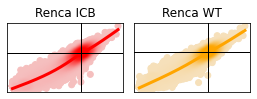

In [14]:
# calculate residuals from natural cubic spline of znorm abundances
resid = pd.DataFrame(index=counts.index)
# get IO and WT colors
pal = ['red', 'orange']

ncols=4
nrows=16//ncols + 16%ncols

plt.figure(None, (ncols*1.8, nrows*1.2))
for i, (s, c) in tqdm(enumerate(zip(invivo_design['Sample'], invivo_design['Control'])), total=len(invivo_design)):
    ax = plt.subplot(nrows, ncols, i+1)
    x = zlog2rpm[c]
    y = zlog2rpm[s]
    #clr='#00adcc'  # for cividis
    clr = pal[i%2]
    
    # calculate spline
    print(x)
    x_basis = cr(x, df=4, constraints='center')
    print(x_basis)
    model = LinearRegression().fit(x_basis, y)
    y_hat = model.predict(x_basis)
    
    # plot points with density
#     cm = plt.cm.cividis
    cm = truncate_colormap(sns.light_palette(clr, as_cmap=True), minval=0.2)
    density_scatter(x, y, ax=ax, cmap=cm)
    ax.set_title(s.replace('_', ' ').replace('IO', 'ICB'))
    idx = np.argsort(x)
    
    ax.plot(x[idx], y_hat[idx], color=clr, linewidth=3)
    ax.axvline(0, linestyle='-', linewidth=1, color='k')
    ax.axhline(0, linestyle='-', linewidth=1, color='k')
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)
#     ax.tick_params(axis='both', which='major', labelsize=9)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
    
    resid[s] = y - y_hat
plt.tight_layout()
plt.show()

100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


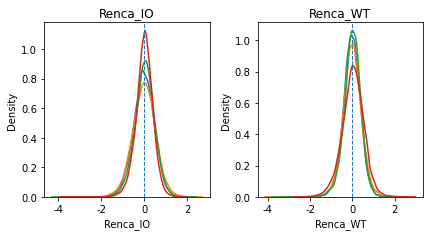

In [13]:
plt.figure(None, (12, 12))
for i, c in tqdm(enumerate(resid.columns), total=len(invivo_design)):
    ax = plt.subplot(4, 4, i+1)
    for j, p in enumerate(chip['pool'].unique()):
        g = chip[chip['pool'] == p].index
        x = resid.loc[g][c]
        
        # plot points with density
        sns.kdeplot(x, ax=ax, color='C'+str(j), label=p)
    ax.set_title(c)

    ax.axvline(0, linestyle='--', linewidth=1)
    ax.axhline(0, linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

In [14]:
for s in resid.columns:
    print('{:20}spearman:{:.4f}\tpearson:{:.4f}'.format(s, spearmanr(resid[s], zlfc[s])[0], pearsonr(resid[s], zlfc[s])[0]))

Renca_IO            spearman:0.9387	pearson:0.9257
Renca_WT            spearman:0.9662	pearson:0.9679


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


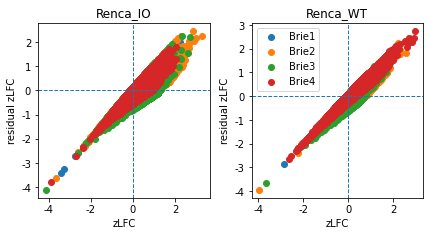

In [15]:
# zLFC vs resid
plt.figure(None, (12, 12))
for i, c in tqdm(enumerate(zlfc.columns), total=len(zlfc.columns)):
    ax = plt.subplot(4, 4, i+1)
    for j, p in enumerate(chip['pool'].unique()):
        g = chip[chip['pool'] == p].index
        x = zlfc.loc[g][c]
        y = resid.loc[g][c]
        ax.scatter(x, y, color='C' + str(j), label=p)
    ax.set_title(c)
    ax.set_xlabel('zLFC')
    ax.set_ylabel('residual zLFC')
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.axhline(0, linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

### qnorm residuals

In [16]:
def qnorm(x):
    t = pd.DataFrame(x)
    rank_mean = t.stack().groupby(t.rank(method='first').stack().astype(int)).mean()
    t = t.rank(method='min').stack().astype(int).map(rank_mean).unstack()
    return t

In [17]:
# from scanpy
def make_index_unique(index: pd.Index, join: str = "-"):
    if index.is_unique:
        return index
    from collections import Counter

    values = index.values.copy()
    indices_dup = index.duplicated(keep="first")
    values_dup = values[indices_dup]
    values_set = set(values)
    counter = Counter()
    issue_interpretation_warning = False
    example_colliding_values = []
    for i, v in enumerate(values_dup):
        while True:
            counter[v] += 1
            tentative_new_name = v + join + str(counter[v])
            if tentative_new_name not in values_set:
                values_set.add(tentative_new_name)
                values_dup[i] = tentative_new_name
                break
            issue_interpretation_warning = True
            if len(example_colliding_values) < 5:
                example_colliding_values.append(tentative_new_name)

    if issue_interpretation_warning:
        print('collision warning:' + str(example_colliding_values))
    values[indices_dup] = values_dup
    index = pd.Index(values, name=index.name)
    return index

In [18]:
# enumerate duplicate genes within pools
tagged_genes = []
for p in chip.pool.unique():
    u = make_index_unique(chip[chip['pool'] == p]['Gene'], join='+')
    tagged_genes.append(u.values)
tagged_genes = np.concatenate(tagged_genes).ravel()

# unique "gene" universe
chip['uniq_genes'] = tagged_genes
uniq_genes = np.unique(tagged_genes)
uniq_genes.shape

(21653,)

In [19]:
# reindex target df with uniq ids to create temporary intermediates with nan
tmp = resid.copy()
res = []
for p in chip['pool'].unique():
    b = tmp.loc[chip[chip['pool'] == p].index]
    b.index = chip[chip['pool'] == p].uniq_genes
    b = b.reindex(uniq_genes)
    res.append(b.values)
res = np.stack(res)
res.shape

(4, 21653, 2)

In [20]:
# interpolate nan guides
interp_res = np.empty_like(res)
for i in tqdm(range(res.shape[2])):
    tmp = pd.DataFrame(res[:, :, i])
    tmp = tmp.fillna(tmp.mean())
    interp_res[:, :, i] = tmp.values

100%|██████████| 2/2 [00:05<00:00,  2.50s/it]


In [21]:
# quantile norm across pools
q_res = np.empty_like(interp_res).transpose(1, 0, 2)
for i in tqdm(range(interp_res.shape[2])):
    q_res[:, :, i] = qnorm(interp_res[:, :, i].T)
print(q_res.shape)

100%|██████████| 2/2 [00:00<00:00, 20.59it/s]

(21653, 4, 2)


In [22]:
# map back to pools, dropping nans
qresid = pd.DataFrame()
for i, p in enumerate(chip['pool'].unique()):
    tc = chip[chip['pool'] == p]
    t = pd.DataFrame(q_res[:, i, :], index=uniq_genes)
    t = t.reindex(tc['uniq_genes'])
    t.index = tc.index
    qresid = pd.concat([qresid, t], axis=0)
qresid.columns = resid.columns

In [27]:
!ls

0_preprocess.ipynb          initial_preprocessing.ipynb
1_preprocess_skeleton.ipynb


In [23]:
# final fold change values-- input to hit calling algorithms
qresid.to_csv("Renca_zresid_guides.txt", sep="\t")

,Renca_IO,Renca_WT
sgRNA,,
s_0,-0.845535,-0.833521
s_1,-0.655765,-0.207999
s_2,0.099138,-0.139370
s_3,-0.173176,-0.093501
s_4,-0.150611,-0.186025
...,...,...
s_82628,0.358945,0.807907
s_82629,0.149184,-0.083421
s_82630,0.168808,0.179558


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


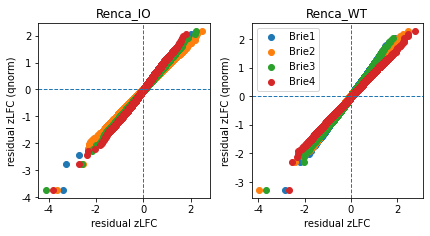

In [25]:
# effect of qnorm
plt.figure(None, (12, 12))
for i, c in tqdm(enumerate(resid.columns), total=len(resid.columns)):
    ax = plt.subplot(4, 4, i+1)
    for j, p in enumerate(chip['pool'].unique()):
        g = chip[chip['pool'] == p].index
        x = resid.loc[g][c]
        y = qresid.loc[g][c]
        ax.scatter(x, y, color='C' + str(j), label=p)
    ax.set_title(c)
    ax.set_xlabel('residual zLFC')
    ax.set_ylabel('residual zLFC (qnorm)')
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.axhline(0, linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


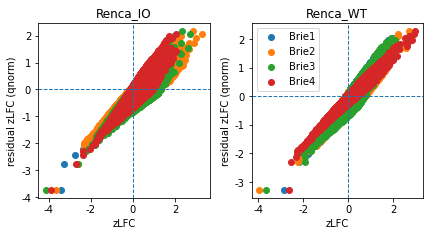

In [26]:
# zLFC vs qnorm resid
plt.figure(None, (12, 12))
for i, c in tqdm(enumerate(zlfc.columns), total=len(zlfc.columns)):
    ax = plt.subplot(4, 4, i+1)
    for j, p in enumerate(chip['pool'].unique()):
        g = chip[chip['pool'] == p].index
        x = zlfc.loc[g][c]
        y = qresid.loc[g][c]
        ax.scatter(x, y, color='C' + str(j), label=p)
    ax.set_title(c)
    ax.set_xlabel('zLFC')
    ax.set_ylabel('residual zLFC (qnorm)')
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.axhline(0, linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()